# 데이터 준비

하버드 glaucoma 파일 전처리(수작업) \
0.8 : 0.1: 0.1 \
Google drive에 Zip형태로 업로드
```
cross validation
788 630 710
289 230 260
467 370 420

glaucoma/
          train/
                normal/ 1~630
                early/ 1~230
                advanced/ 1~370
          valid/
                normal/ 631~710
                early/ 231~260
                advanced/ 371~420
          test/
                normal/ 711~788
                early/ 261~289
                advanced/ 421~467
````


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 경로 복사해서 copy
!cp '/content/drive/MyDrive/Colab Notebooks/temp/glaucoma.zip' ./

In [ ]:
!unzip glaucoma.zip

In [ ]:
!apt-get install tree

In [ ]:
!tree -d glaucoma

glaucoma
├── test
│   ├── advanced
│   ├── early
│   └── normal
├── train
│   ├── advanced
│   ├── early
│   └── normal
└── valid
    ├── advanced
    ├── early
    └── normal

12 directories


# 전이학습 시도
- conv_layers.trainable = False

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 256)               17662208  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 25,432,572
Trainable params: 17,663,491
Non

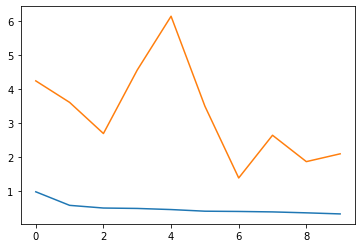

3/3 [==============================] - 1s 227ms/step - loss: 2.4417 - acc: 0.4740
loss= 2.441735029220581
acc= 0.4740259647369385


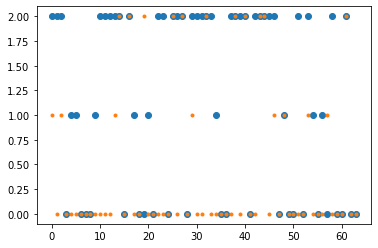

label category index = 2.0
predicted category index = 1
predicted category name = early


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

# 전이학습 시도2
- conv_layers.trainable = True

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               17662208  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 25,432,572
Trainable params: 25,364,485
Non-trainable params: 68,087
_____________________________________

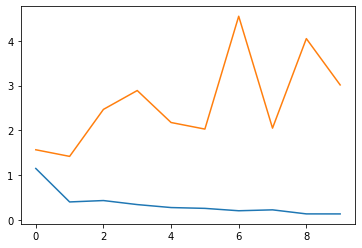

3/3 [==============================] - 1s 129ms/step - loss: 4.0429 - acc: 0.5779
loss= 4.042932033538818
acc= 0.5779221057891846


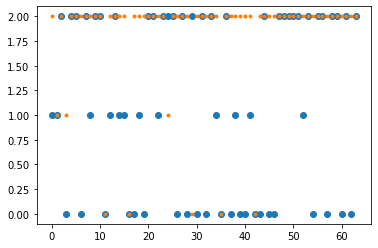

label category index = 1.0
predicted category index = 2
predicted category name = normal


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = True #<-- change
# 

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

## 중간정리1
```

=================================================================
Total params: 25,432,572
Trainable params: 17,663,491
Non-trainable params: 7,769,081
loss= 2.441735029220581
acc= 0.4740259647369385
_________________________________________________________________
Total params: 25,432,572
Trainable params: 25,364,485
Non-trainable params: 68,087
loss= 4.042932033538818
acc= 0.5779221057891846

conv_layers.trainable = True -> 학습 가능 파라미터 수가 증가
acc -> 증가 적음
```

# vanila CNN으로

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

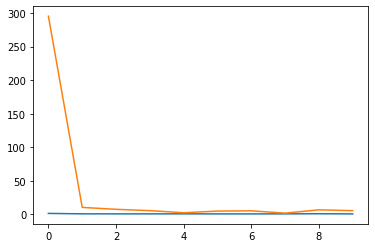

3/3 [==============================] - 1s 425ms/step - loss: 6.5330 - acc: 0.3052
loss= 6.533035755157471
acc= 0.30519479513168335


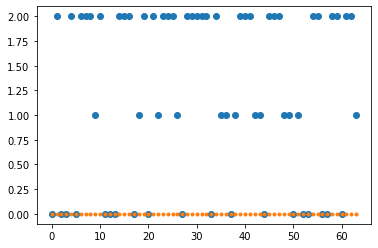

label category index = 0.0
predicted category index = 0
predicted category name = advanced


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

## 중간정리2
```

=================================================================
Total params: 25,432,572
Trainable params: 17,663,491
Non-trainable params: 7,769,081
loss= 2.441735029220581
acc= 0.4740259647369385
_________________________________________________________________
Total params: 25,432,572
Trainable params: 25,364,485
Non-trainable params: 68,087
loss= 4.042932033538818
acc= 0.5779221057891846
_________________________________________________________________
Total params: 21,139,267
Trainable params: 21,138,755
Non-trainable params: 512
loss= 6.533035755157471
acc= 0.30519479513168335
_________________________________________________________________
conv_layers.trainable = True -> 학습 가능 파라미터 수가 증가
acc -> 증가 적음
```

#  vanila CNN으로 (learning_rate 조절)
- 그래프가 날뛰는 것을 가라앉히기 위해서

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

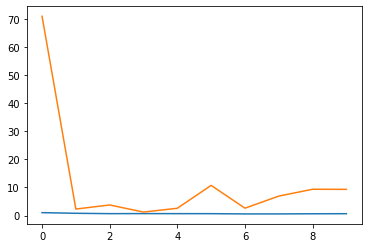

3/3 [==============================] - 1s 151ms/step - loss: 11.6653 - acc: 0.2987
loss= 11.665277481079102
acc= 0.29870128631591797


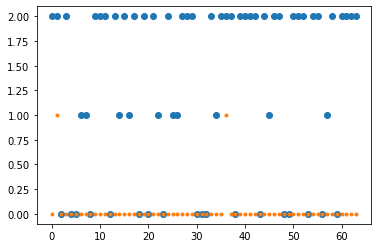

label category index = 2.0
predicted category index = 0
predicted category name = advanced


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow 
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.001) #<---- add

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

In [ ]:
train_data_generator.batch_size = 1000
batch_x, batch_y = train_data_generator.next()
print(batch_x.shape)
print(batch_y.shape)

(230, 224, 224, 3)
(230,)


# optimizer -> Adam
- 성능상향이 안되는 것 보니 optimizer 궁합이 안맞을 수도 있다.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

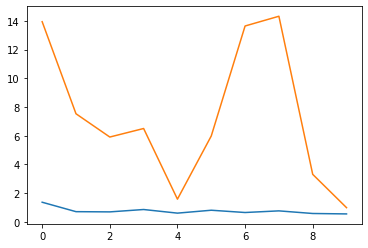

3/3 [==============================] - 1s 143ms/step - loss: 1.2897 - acc: 0.4286
loss= 1.2896885871887207
acc= 0.4285714328289032


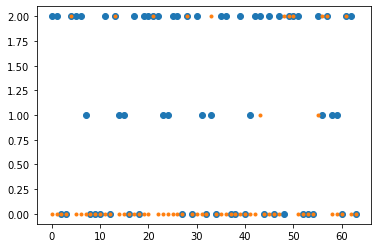

label category index = 2.0
predicted category index = 0
predicted category name = advanced


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow 
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001) #<---- change

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

## epoch 값을 올려본다.

Epoch 1/100
20/20 [==============================] - 16s 775ms/step - loss: 0.5639 - acc: 0.7610 - val_loss: 3.5558 - val_acc: 0.3187
Epoch 2/100
20/20 [==============================] - 16s 762ms/step - loss: 0.5678 - acc: 0.7602 - val_loss: 5.3508 - val_acc: 0.5125
Epoch 3/100
20/20 [==============================] - 16s 767ms/step - loss: 0.5617 - acc: 0.7789 - val_loss: 2.7609 - val_acc: 0.5125
Epoch 4/100
20/20 [==============================] - 16s 764ms/step - loss: 0.8370 - acc: 0.6862 - val_loss: 1.6926 - val_acc: 0.4875
Epoch 5/100
20/20 [==============================] - 16s 762ms/step - loss: 0.5408 - acc: 0.7691 - val_loss: 0.9432 - val_acc: 0.6375
Epoch 6/100
20/20 [==============================] - 16s 765ms/step - loss: 0.5574 - acc: 0.7707 - val_loss: 1.2542 - val_acc: 0.6625
Epoch 7/100
20/20 [==============================] - 16s 764ms/step - loss: 0.5362 - acc: 0.7732 - val_loss: 1.1496 - val_acc: 0.5000
Epoch 8/100
20/20 [==============================] - 16s 762ms

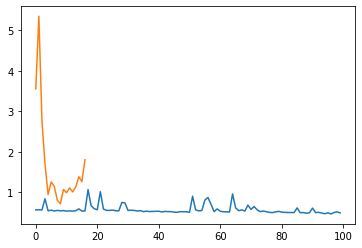

3/3 [==============================] - 1s 143ms/step - loss: nan - acc: 0.3052
loss= nan
acc= 0.30519479513168335


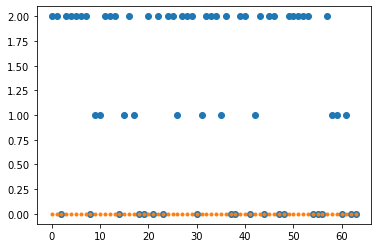

label category index = 2.0
predicted category index = 0
predicted category name = advanced


In [ ]:
history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=100 #<--- change
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

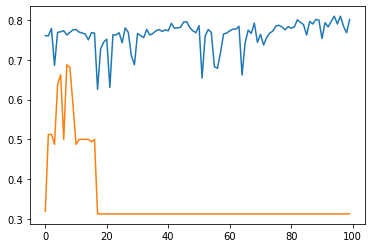

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [ ]:
# 아 이거 batchsize랑 conv가 너무 큰가...?
# 왜 nan값이 뜨지...?

## ConV 레이어 작게
- epoch 값을 10으로

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 conv2d_41 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 conv2d_43 (Conv2D)          (None, 112, 112, 32)      9248      
                                                      

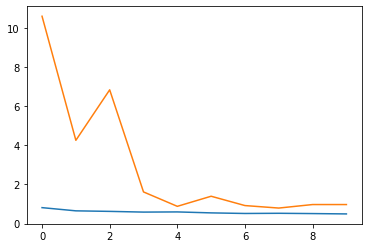

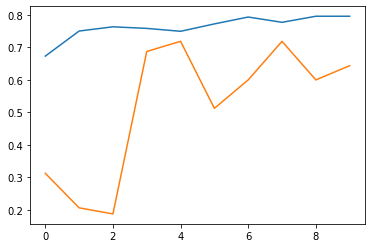

3/3 [==============================] - 1s 194ms/step - loss: 1.1196 - acc: 0.5584
loss= 1.119615077972412
acc= 0.5584415793418884


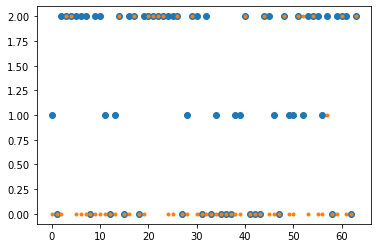

label category index = 1.0
predicted category index = 0
predicted category name = advanced


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(128, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


In [ ]:
# 와 acc 값이 올랐어
# loss= 1.119615077972412
# acc= 0.5584415793418884

## ConV 레이어 더 작게

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      9248      
                                                        

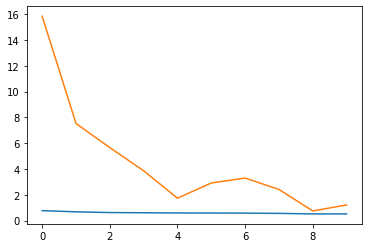

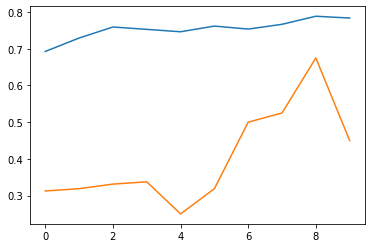

3/3 [==============================] - 1s 187ms/step - loss: 1.3303 - acc: 0.4351
loss= 1.3303250074386597
acc= 0.4350649416446686


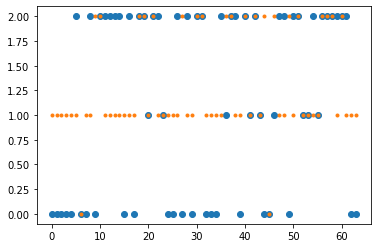

label category index = 0.0
predicted category index = 1
predicted category name = early


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(32, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(Conv2D(64, (3,3), padding='same'))   # <-----------------------
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


In [ ]:
# 이렇게 해도 '0'에 머물러 있네.....

In [ ]:
# 런타임 끊겼다
# 이번에는 '1'이 대부분이네
# 런타임 끊겨서 다시돌렸더니 acc= 0.4350649416446686 로 더 떨어졌네...

## 데이터 다시 확인(전처리)

(32, 224, 224, 3)
(32,)


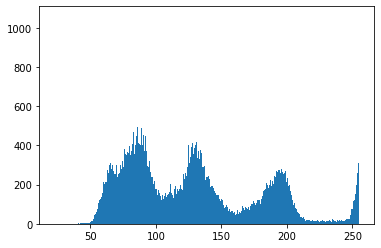

In [ ]:
train_data_generator.batch_size=32
batch_x, batch_y = train_data_generator.next()
print(batch_x.shape)
print(batch_y.shape)

plt.hist(batch_x[0].flatten(), bins=1000)
plt.show()

In [ ]:
# 아...scale
# 이미지가 preprocess_input 과 호환이 안되나??
# 그 이유가 EfficientNetB2 전이 학습이 아닌 vanila을 사용해서 그런가?
# 그럼 직접 scaling 해보자

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      9248      
                                                      

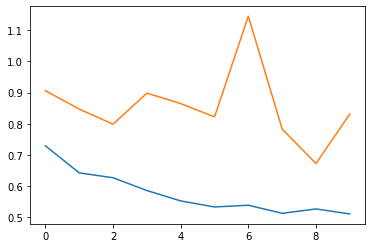

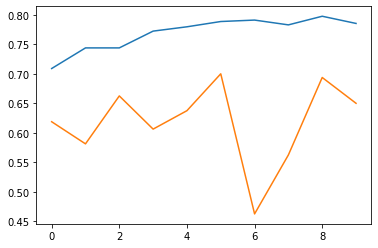

3/3 [==============================] - 1s 136ms/step - loss: 1.1851 - acc: 0.5390
loss= 1.1850835084915161
acc= 0.5389610528945923


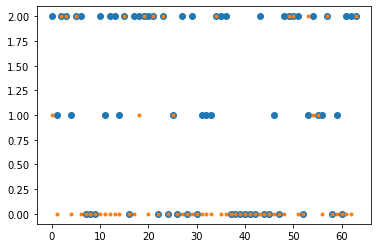

label category index = 2.0
predicted category index = 1
predicted category name = early


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      rescale=1/255.,   # <-----------------------
      # preprocessing_function=preprocessor   # <-----------------------
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      rescale=1/255.,   # <-----------------------
      # preprocessing_function=preprocessor   # <-----------------------
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      rescale=1/255.,   # <-----------------------
      # preprocessing_function=preprocessor   # <-----------------------
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


In [ ]:
# acc= 0.5389610528945923 오 다시 올라갔다.

(32, 224, 224, 3)
(32,)


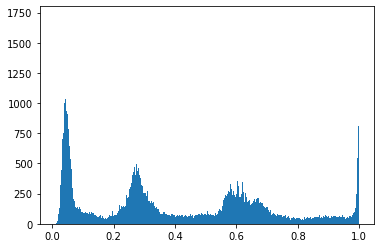

In [ ]:
train_data_generator.batch_size=32
batch_x, batch_y = train_data_generator.next()
print(batch_x.shape)
print(batch_y.shape)

plt.hist(batch_x[0].flatten(), bins=1000)
plt.show()

In [ ]:
# 흠.... Learning Rate 더 줄이고, epoch 수 많이해보자

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      9248      
                                                      

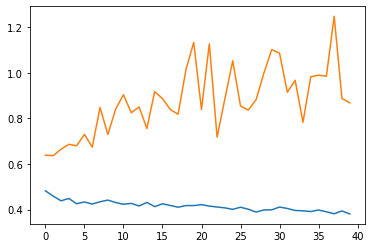

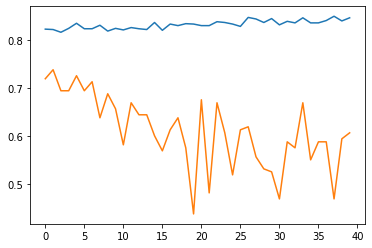

3/3 [==============================] - 1s 139ms/step - loss: 1.0952 - acc: 0.5390
loss= 1.0951664447784424
acc= 0.5389610528945923


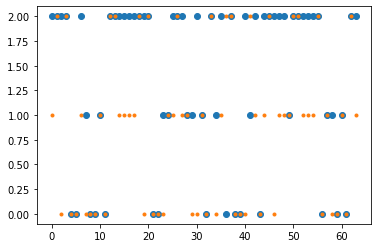

label category index = 2.0
predicted category index = 1
predicted category name = early


In [ ]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001*0.1)  # <-----------------------
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      rescale=1/255.,
      # preprocessing_function=preprocessor 
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

valid_data_generator = ImageDataGenerator(
      rescale=1/255.
      # preprocessing_function=preprocessor 
).flow_from_directory(
      "glaucoma/valid",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      rescale=1/255., 
      # preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=40  # <-----------------------
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

In [ ]:
# acc= 0.5389610528945923
# Learning rate, epochs을 늘린다고 잘되는게 아닌것 같은데....
# 학습이 부족한가??

# 논문 찾아보기

```
A deep learning model for the detection of both advanced and early glaucoma using fundus photography

PLoS One, 13 (11), e0207982 2018 Nov 27 eCollection 2018

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0207982
```


논문 내용: \
 1. GoogleNet Inception v3로 전이학습
 2. Inception v3 모델의 마지막 분류 계층을 수정한 다음 데이터를 사용하여 미세 조정 
 3. Two convolutional layers, with patch sizes of 20x20 and 40x40, were used with a stride of 1 and depths of 16 and 32. Max pooling was applied, with a patch size of 22 and a stride of 2
 4. 32 및 64개의 은닉 유닛이 완전 연결 레이어
 5. 0.5의 드롭아웃 
 6. 활성화 함수로 ReLu(Rectifier Linear unit) 
 7. 역전파의 경우 손실 함수로 교차 엔트로피
 8. 최적화 함수로 Adagrad 옵티마이저
 9. 증강 데이터(사진당 10개의 이미지)
 10. 모델 평가: ROC, sensitivity, specificity
 

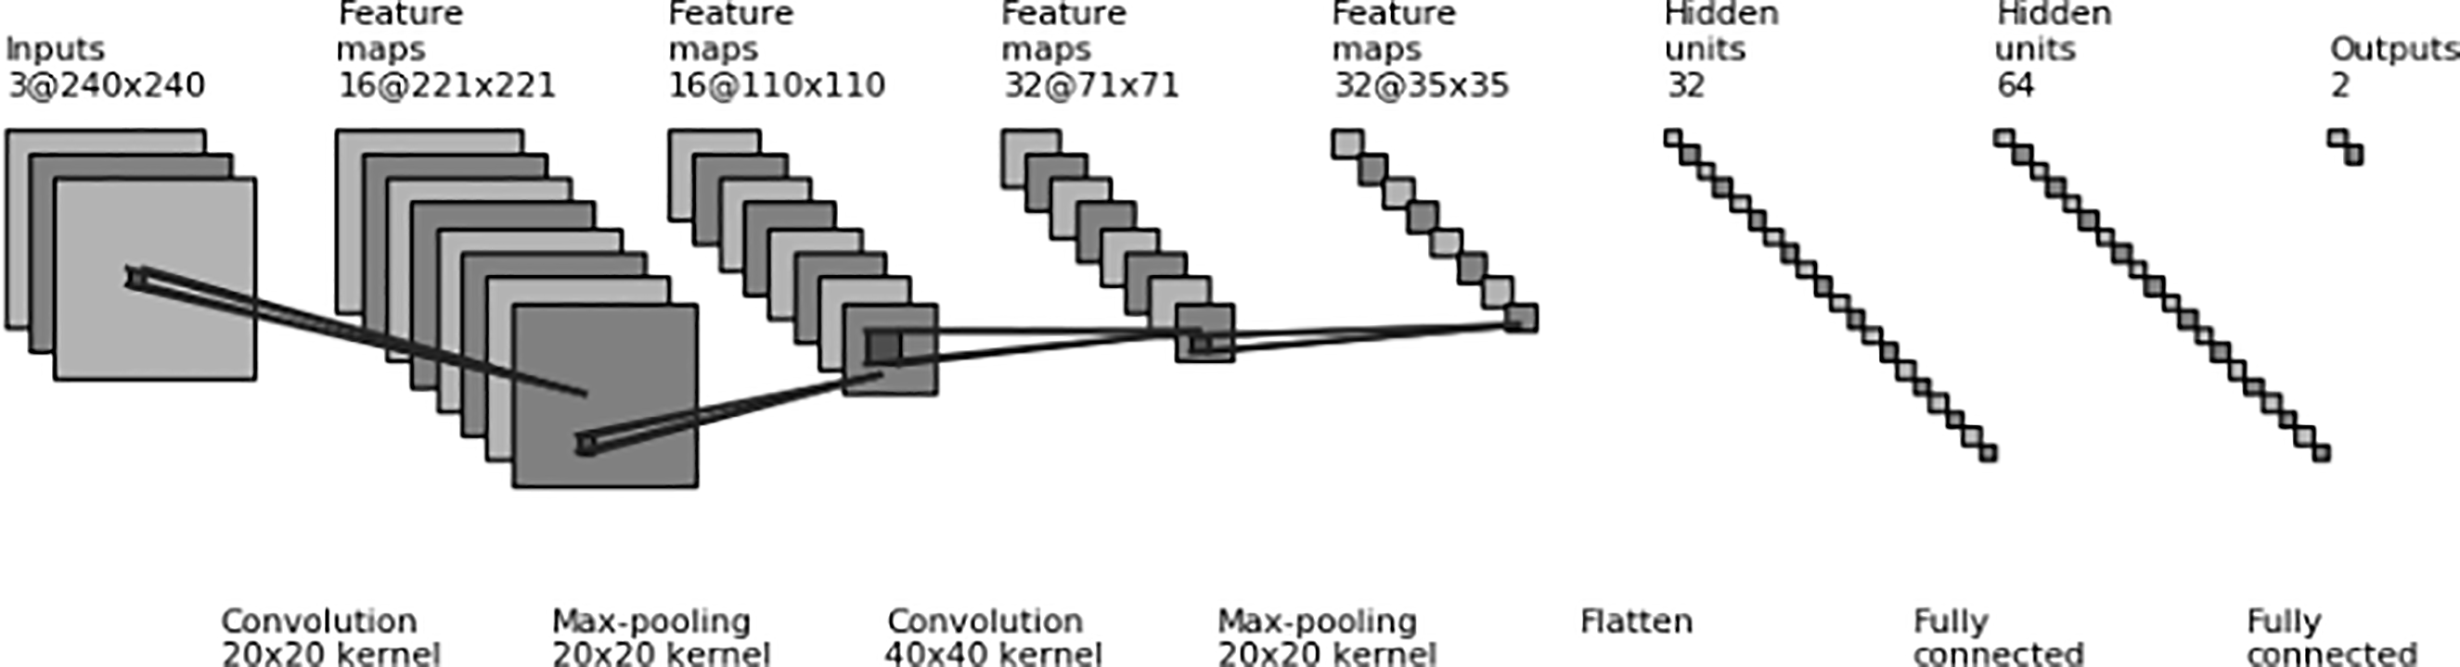

Google Inception Model. 정리 사이트 \
https://norman3.github.io/papers/docs/google_inception.html
